In [140]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si
import os

In [141]:
rcr = yf.download("AMZN", start="2020-03-10", end="2021-03-10")

[*********************100%***********************]  1 of 1 completed


In [142]:
rcr.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-10,1870.880005,1894.270020,1818.170044,1891.819946,1891.819946,7133300
2020-03-11,1857.849976,1871.319946,1801.500000,1820.859985,1820.859985,5624800
2020-03-12,1721.979980,1765.000000,1675.000000,1676.609985,1676.609985,11346200
2020-03-13,1755.000000,1786.310059,1680.619995,1785.000000,1785.000000,8809700
2020-03-16,1641.510010,1759.449951,1626.030029,1689.150024,1689.150024,8917300


In [143]:
rcr['Adj Close']

Date
2020-03-10    1891.819946
2020-03-11    1820.859985
2020-03-12    1676.609985
2020-03-13    1785.000000
2020-03-16    1689.150024
                 ...     
2021-03-03    3005.000000
2021-03-04    2977.570068
2021-03-05    3000.459961
2021-03-08    2951.949951
2021-03-09    3062.850098
Name: Adj Close, Length: 252, dtype: float64

In [144]:
rc = rcr['Adj Close']

In [145]:
rc

Date
2020-03-10    1891.819946
2020-03-11    1820.859985
2020-03-12    1676.609985
2020-03-13    1785.000000
2020-03-16    1689.150024
                 ...     
2021-03-03    3005.000000
2021-03-04    2977.570068
2021-03-05    3000.459961
2021-03-08    2951.949951
2021-03-09    3062.850098
Name: Adj Close, Length: 252, dtype: float64

<AxesSubplot:xlabel='Date'>

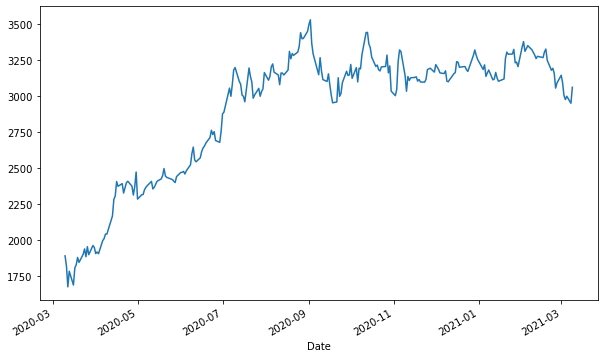

In [146]:
rc.plot(figsize=(10, 6))

In [147]:
logrc = np.log(rc / rc.shift(1))
logrc.head().round(4)

Date
2020-03-10       NaN
2020-03-11   -0.0382
2020-03-12   -0.0825
2020-03-13    0.0626
2020-03-16   -0.0552
Name: Adj Close, dtype: float64

In [148]:
vol = logrc.std() * (252 ** 0.5)
print(' volatility for one year is %.8f' % (vol))

 volatility for one year is 0.37261605


In [149]:
cvol = logrc[126:-1]

In [150]:
cvolc = cvol.std() * (252 ** 0.5)

In [151]:
cvolc

0.32769862456002113

In [152]:
def binaryoption(S, St, T, rf, di, vol, pf):
    
    #S: spot price
    #St: strike price
    #T: time to maturity
    #rf: risk free rate
    #di: continuous dividend yield
    #vol: volatility of underlying asset
    #pf: call or put
    
    d1 = (np.log(S / St) + (rf - di + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / St) + (rf - di - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if pf == "call":
        option_value = np.exp(-rf * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif pf == "put":
        option_value = np.exp(-rf * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [153]:
binaryoption(3052.03,3087.07,1/12,0.0167,0,0.3726,'put')

0.5576465825683506

In [154]:
def delta(S,St,T,rf,di,vol,pf):
    d1 = (np.log(S/St) + (rf + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S/St) + (rf - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    
    if pf == 'call':
        delta =  (np.exp(-rf*T))*si.norm.pdf(d2,0.0,1.0)/(vol*S*np.sqrt(T))
    elif pf == 'put':
        delta = -(np.exp(-rf*T)*si.norm.pdf(d2,0.0,1.0))/(vol*S*np.sqrt(T))

    return delta

In [155]:
delta(3052.03,3087.07,1/12,0.0167,0,0.3726,'put')

-0.0012005328843442264

In [156]:
def gamma(S,St,T,rf,di,vol,pf):
    d1 = (np.log(S/St) + (rf + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S/St) + (rf - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    
    if pf == 'call':
        gamma = (np.exp(-rf*T)*d1*si.norm.pdf(d2,0.0,1.0))/((vol**2)*(S**2)*(T))
    elif pf == 'put':
        gamma = -(np.exp(-rf*T)*d1*si.norm.pdf(d2,0.0,1.0))/((vol**2)*(S**2)*(T))

    return gamma

In [157]:
gamma(3052.03,3087.07,1/12,0.0167,0,0.3726,'put')

1.4413330285238026e-07

In [158]:
def theta(S,St,T,rf,di,vol,pf):
    d1 = (np.log(S/St) + (rf + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S/St) + (rf - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    a = d1/(2*T)
    b = (rf-di)/(vol*np.sqrt(T))
    if pf == 'call':
        theta = (rf* np.exp(-rf*T)*(si.norm.cdf(d2,0.0,1.0)))+(np.exp(-rf*T)*si.norm.pdf(d2,0.0,1.0))* (a-b)
    elif pf == 'put':
        theta = (rf* np.exp(-rf*T)*(1- si.norm.cdf(d2,0.0,1.0)))-(np.exp(-rf*T)*si.norm.pdf(d2,0.0,1.0))* (a-b)

    return theta

In [159]:
theta(3052.03,3087.07,1/12,0.0167,0,0.3726,'put')

0.1636986186048526

In [160]:
def speed(S,St,T,rf,di,vol,pf):
    d1 = (np.log(S/St) + (rf + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S/St) + (rf - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    a= (np.exp(-rf*T)*si.norm.pdf(d2,0.0,1.0))/((vol**2)*(S**3)*(T))
    b= ((-2*d1)+((1-(d1*d2))/(vol*np.sqrt(T))))
    
    if pf == 'call':
        speed = -a*b
    elif pf == 'put':
        speed = a*b

    return speed
    

In [161]:
speed(3052.03,3087.07,1/12,0.0167,0,0.3726,'put')

1.1170095958619412e-08

In [162]:
def vega(S,St,T,rf,di,vol,pf):
    d1 = (np.log(S/St) + (rf + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S/St) + (rf - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    a = (np.sqrt(T) + ((d2)/vol))   
    if pf == 'call':
        vega = (-np.exp(-rf*T)*si.norm.pdf(d2,0.0,1.0)) * a
    elif pf == 'put':
        vega = (np.exp(-rf*T)*si.norm.pdf(d2,0.0,1.0)) * a
            
    return vega

In [163]:
vega(3052.03,3087.07,1/12,0.0167,0,0.3726,'put')

-0.04168727811172656

In [164]:
S = 3052.03              # spot stock price
St = 3087.07               # strike
T = 1/12                 # maturity 
rf = 0.0167                 # risk free rate 
vol = 0.3726               # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "put"          # payoff

In [165]:
dT = float(T) / N                             # Delta t
u = np.exp(vol * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor

In [166]:
Sc = np.zeros((N + 1, N + 1))
Sc[0, 0] = S
z = 1
for t in range(1, N + 1):
    for i in range(z):
        Sc[i, t] = Sc[i, t-1] * u
        Sc[i+1, t] = Sc[i, t-1] * d
    z += 1

In [167]:
Sc

array([[3052.03      , 3247.56973572, 3455.63745715, 3677.03581664],
       [   0.        , 2868.26392624, 3052.03      , 3247.56973572],
       [   0.        ,    0.        , 2695.56260933, 2868.26392624],
       [   0.        ,    0.        ,    0.        , 2533.25982814]])

In [168]:
a = np.exp(rf * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.48821346886357236

In [186]:
S_T = Sc[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.heaviside(S_T-St, 0.0)
elif payoff =="put":
    V[:,-1] = np.heaviside(St-S_T, 0.0)
V

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [199]:
if payoff =="call":
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            V[i,j] = np.heaviside(S[i,j] - St,np.exp(-rf*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]))
elif payoff =="put":
    for j in range(N-1,-1,-1):
        for i in range(j+1):
            V[i,j] = np.heaviside(St - S[i,j],np.exp(-rf*dT) * (p * V[i,j+1] + q * V[i+ 1,j+1]))
V

TypeError: 'float' object is not subscriptable